In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sc

In [2]:
knmi_data = pd.read_csv('data/knmi_data_weather.txt', skiprows=9, index_col=1, parse_dates=True, skipinitialspace=True)
rws_discharge_data = pd.read_csv('data/rws_data_discharge.csv', delimiter=';', parse_dates=[['WAARNEMINGDATUM', 'WAARNEMINGTIJD (MET/CET)']], index_col=0)
rws_water_temp_data = pd.read_csv('data/rws_data_watertemp.csv', delimiter=';', parse_dates=[['WAARNEMINGDATUM', 'WAARNEMINGTIJD (MET/CET)']], index_col=0)

C:\Users\mauro\AppData\Local\Temp\ipykernel_19660\3462304345.py:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  rws_water_temp_data = pd.read_csv('data/rws_data_watertemp.csv', delimiter=';', parse_dates=[['WAARNEMINGDATUM', 'WAARNEMINGTIJD (MET/CET)']], index_col=0)


In [3]:
discharge = pd.DataFrame(rws_discharge_data['ALFANUMERIEKEWAARDE'])
discharge.index = pd.to_datetime(discharge.index, format='%d/%m/%Y %H:%M:%S')
temperature = pd.DataFrame(rws_water_temp_data['ALFANUMERIEKEWAARDE'])
temperature.index = pd.to_datetime(temperature.index, format='%d/%m/%Y %H:%M:%S')
precipitation = pd.DataFrame(knmi_data.loc['2010':]['RH'] / 10)
discharge = discharge.rename(columns={'ALFANUMERIEKEWAARDE': 'Discharge (m3/s)'})
temperature = temperature.rename(columns={'ALFANUMERIEKEWAARDE': 'Temperature (C)'})

In [4]:
temperature.max()

Temperature (C)    27.1
dtype: float64

In [5]:
discharge_W = discharge.resample('W').mean()
precipitation_W = precipitation.resample('W').sum()
temperature_W = temperature.resample('W').mean()
total_data = pd.concat([discharge_W, precipitation_W, temperature_W], axis=1).dropna()
total_data = total_data.rename(columns={'Discharge (m3/s)': 'Discharge', 'RH': 'Precipitation', 'Temperature (C)': 'Water temperature'})
keys = total_data.keys()

total_data.loc['2021']

,Discharge,Precipitation,Water temperature
2021-01-03,931.522569,5.8,6.419005


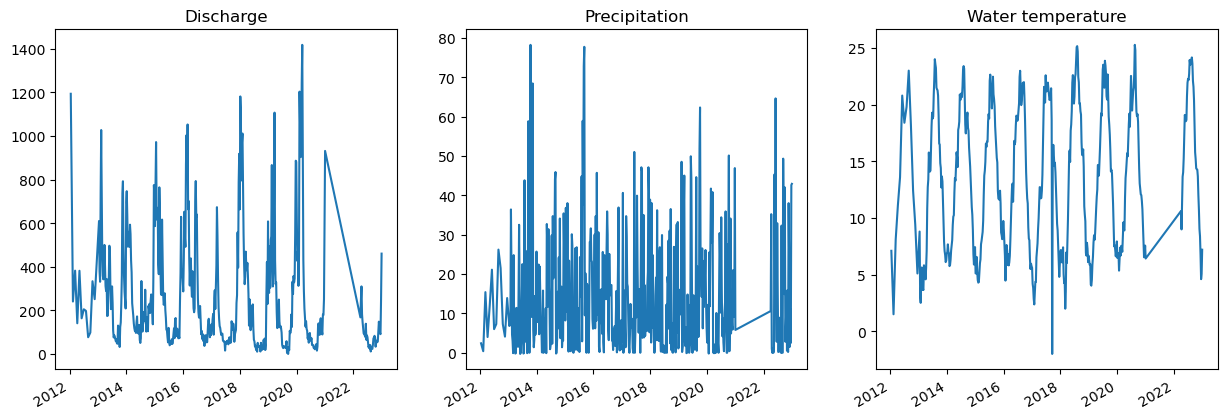

In [6]:
def plotter(data, keys):
    plt.figure(figsize=(15, 5))
    for i, key in enumerate(keys):
        ax = plt.subplot(1, 3, i + 1)
        data[key].plot(ax=ax)
        plt.title(f'{key}')
plotter(total_data, keys)



Discharge
self.slope=-1.599e+01, self.intercept=3.252e+04, self.rvalue=-1.724e-01, self.pvalue=1.729e-04, self.stderr=4.224e+00, self.intercept_stderr=8.521e+03
Precipitation
self.slope=1.241e-01, self.intercept=-2.358e+02, self.rvalue=2.347e-02, self.pvalue=6.117e-01, self.stderr=2.443e-01, self.intercept_stderr=4.929e+02
Water temperature
self.slope=2.866e-01, self.intercept=-5.647e+02, self.rvalue=1.286e-01, self.pvalue=5.222e-03, self.stderr=1.021e-01, self.intercept_stderr=2.061e+02


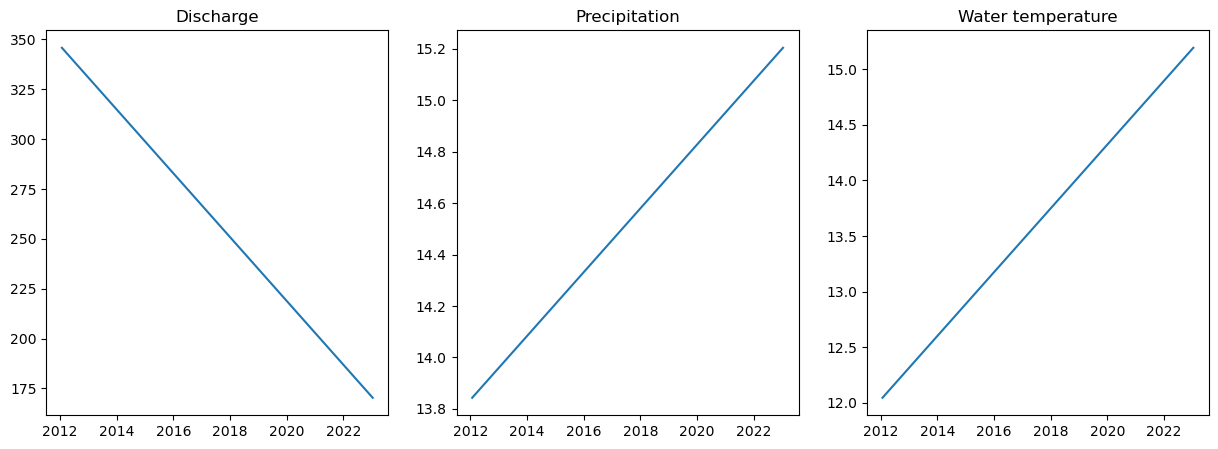

In [7]:
class linear_obj:
    def __init__(self, result, name, x):
        self.name = name
        self.slope = result.slope
        self.intercept = result.intercept
        self.rvalue = result.rvalue
        self.pvalue = result.pvalue
        self.stderr = result.stderr
        self.intercept_stderr = result.intercept_stderr
        self.x = x
        
    def print_values(self):
        print(self.name)
        print(f'{self.slope=:.3e}, {self.intercept=:.3e}, {self.rvalue=:.3e}, {self.pvalue=:.3e}, {self.stderr=:.3e}, {self.intercept_stderr=:.3e}')
  
    def linear_line(self, plot=False):
        self.y = self.intercept + self.slope * self.x      
        if plot:
            plt.title(self.name)
            plt.plot(self.x, self.y)
        
linearity = []

def linear(data, keys):  
    plt.figure(figsize=(15, 5))
    for i, key in enumerate(keys):
        x = data[key].index.values.astype(float) / (1e9 * 86400 * 365) + 1970
        y = data[key].values
        
        result = sc.stats.linregress(x, y)
        linearity.append(linear_obj(result, key, x))
        linearity[i].print_values()
        plt.subplot(1, 3, i + 1)
        linearity[i].linear_line(plot=True)
 
linear(total_data, keys)    


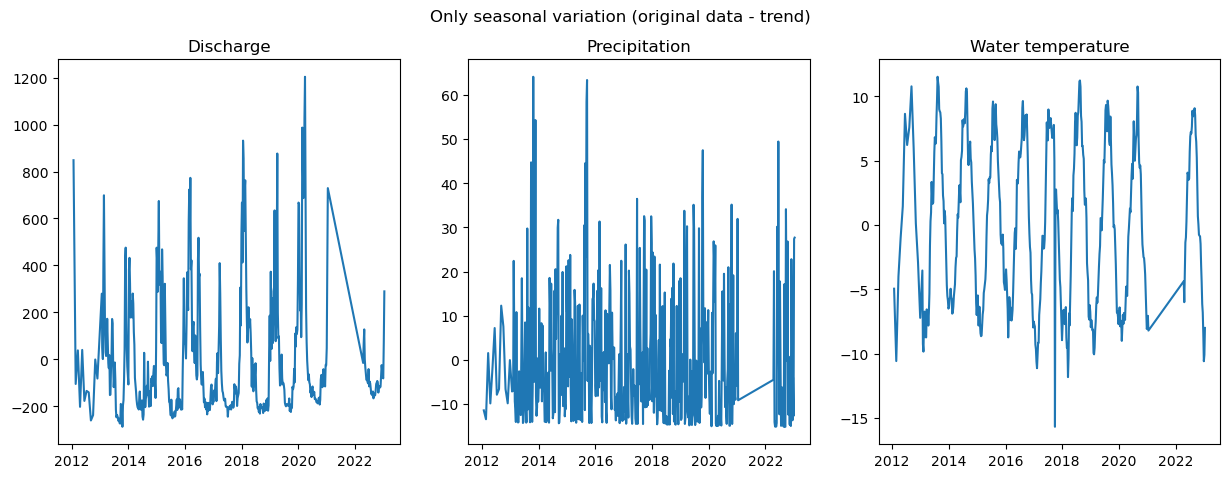

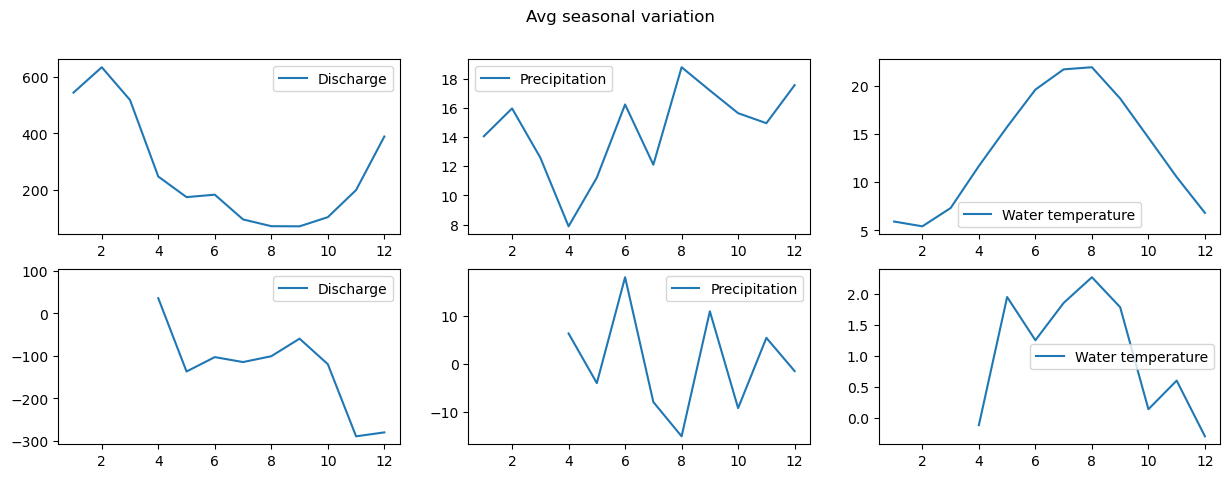

<Figure size 1500x500 with 0 Axes>

In [8]:
class seasonal_obj:
    def __init__(self, name, xy):
        self.name = name
        self.x, self.y = xy
        
    def plotter(self):
        plt.title(self.name)
        plt.plot(self.x, self.y)
    
seasonality = []
def seasonal(data, keys):
    plt.figure(figsize=(15, 5))
    plt.suptitle('Only seasonal variation (original data - trend)')
    for i, key in enumerate(keys):
        seasonality.append(seasonal_obj(key, (linearity[i].x, data[key] - linearity[i].y)))
        axes = plt.subplot(1, 3, i + 1)
        seasonality[i].plotter()
        
    plt.figure(figsize=(15, 5))
    plt.suptitle('Avg seasonal variation')
    

    for i, key in enumerate(keys):    
        month_avg = pd.DataFrame(data[key].groupby(data[key].index.month).mean())
        axes = plt.subplot(2, 3, i + 1)
        month_avg.plot(ax = axes)
        
        first_3_years = total_data[total_data[key].index.year <= total_data[key].index.year.min() + 2]
        last_3_years = total_data[total_data[key].index.year >= total_data[key].index.year.max() - 2]
        last_3_mean = last_3_years[key].groupby(last_3_years[key].index.month).mean()
        first_3_mean = first_3_years[key].groupby(first_3_years[key].index.month).mean()
        difference = pd.DataFrame(last_3_mean - first_3_mean)
        axes = plt.subplot(2, 3, i + 4)
        difference.plot(ax=axes)        
        
    plt.figure(figsize=(15, 5))
    plt.suptitle('Change in seasonal average variation')
    
        
seasonal(total_data, keys)